In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

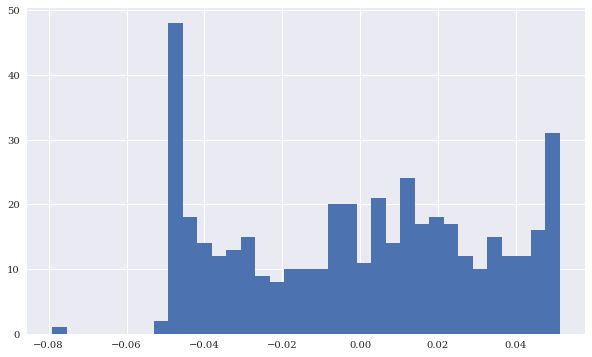

In [2]:
'''
Iran.Kh..Inv..csv
Iran.Khodro.csv
Jahrom.Power.Plant.csv
'''

raw = pd.read_csv('Jahrom.Power.Plant.csv',index_col=1, parse_dates=True)
symbol = '<CLOSE>'
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data['returns']).astype(int)
data['returns'].hist(bins=35, figsize=(10, 6));


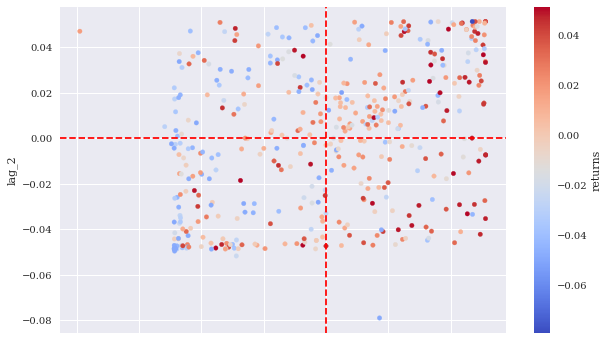

In [5]:
lags = 2
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
create_lags(data)
data.dropna(inplace=True)
data.plot.scatter(x='lag_1', y='lag_2', c='returns',cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
data['pos_ols_1'] = model.fit(data[cols],
data['returns']).predict(data[cols])
data['pos_ols_2'] = model.fit(data[cols],
data['direction']).predict(data[cols])
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
<DTYYYYMMDD>,,
2021-07-28,0.001624,0.067641
2021-07-27,-0.004445,-0.068326
2021-07-26,0.013863,0.356894
2021-07-19,0.011783,0.348931
2021-07-18,-0.009500,-0.153864


In [7]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [8]:
data['pos_ols_1'].value_counts()

 1    228
-1    208
Name: pos_ols_1, dtype: int64

In [9]:
data['pos_ols_2'].value_counts()

 1    241
-1    195
Name: pos_ols_2, dtype: int64

In [10]:
(data['pos_ols_1'].diff() != 0).sum()

194

In [11]:
(data['pos_ols_2'].diff() != 0).sum()

180

In [12]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns         0.811914
strat_ols_1    93.917378
strat_ols_2    69.519387
dtype: float64

In [13]:
(data['direction'] == data['pos_ols_1']).value_counts()

True     273
False    163
dtype: int64

In [14]:
(data['direction'] == data['pos_ols_2']).value_counts()

True     274
False    162
dtype: int64

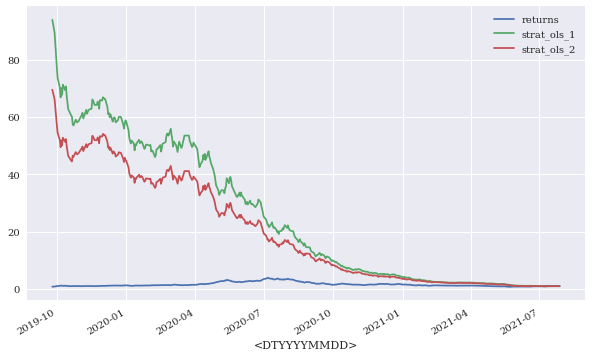

In [15]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6));

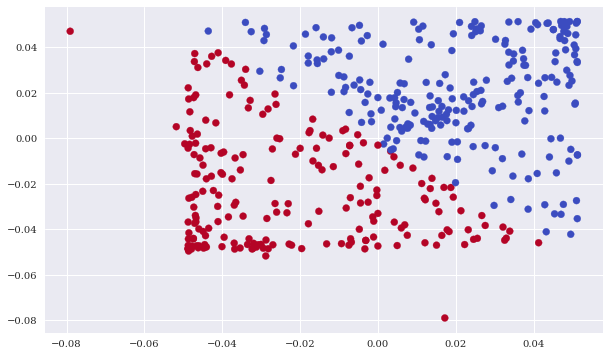

In [16]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, random_state=0)
model.fit(data[cols])
data['pos_clus'] = model.predict(data[cols])
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)
data['pos_clus'].values
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],c=data['pos_clus'], cmap='coolwarm');

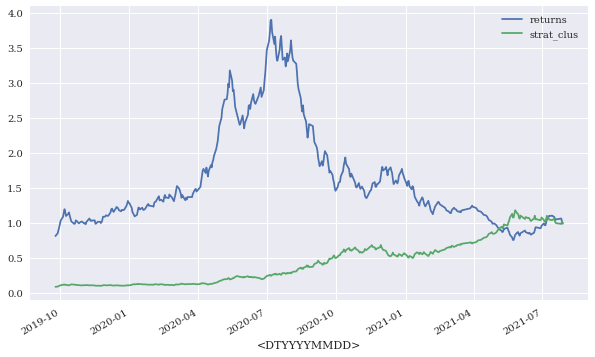

In [17]:
data['strat_clus'] = data['pos_clus'] * data['returns']
data[['returns', 'strat_clus']].sum().apply(np.exp)
(data['direction'] == data['pos_clus']).value_counts()
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [19]:
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)
create_bins(data)
data[cols_bin + ['direction']].head()
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           81
                       0            3
                       1           45
           1          -1           49
                       1           32
1          0          -1           28
                       0            1
                       1           52
           1          -1           53
                       1           92
dtype: int64

In [20]:
res = grouped['direction'].size().unstack(fill_value=0)
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
res.style.apply(highlight_max, axis=1)

In [21]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)
(data['direction'] == data['pos_freq']).value_counts()

False    254
True     182
dtype: int64

In [22]:
data['strat_freq'] = data['pos_freq'] * data['returns']
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.811914
strat_freq    0.103398
dtype: float64

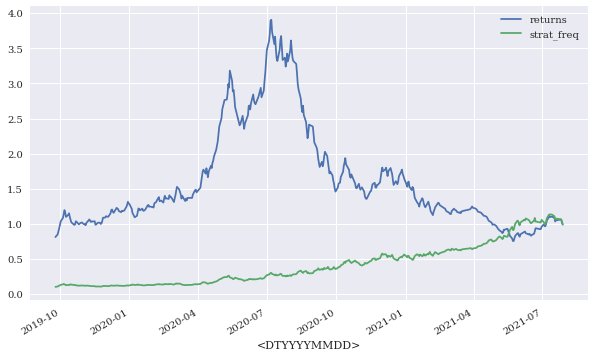

In [23]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

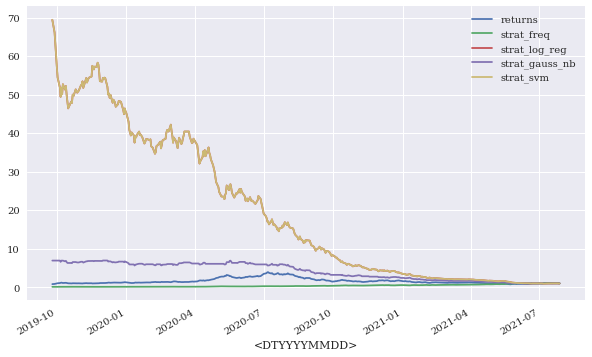

In [24]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
C = 1
models = {
'log_reg': linear_model.LogisticRegression(C=C),
'gauss_nb': GaussianNB(),
'svm': SVC(C=C)}
def fit_models(data):
    mfit = {model: models[model].fit(data[cols_bin],data['direction']) for model in models.keys()}
fit_models(data)
def derive_positions(data):
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
derive_positions(data)
def evaluate_strats(data):
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')
evaluate_strats(data)
sel.insert(1, 'strat_freq')
data[sel].sum().apply(np.exp)
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

C:\Users\BB\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


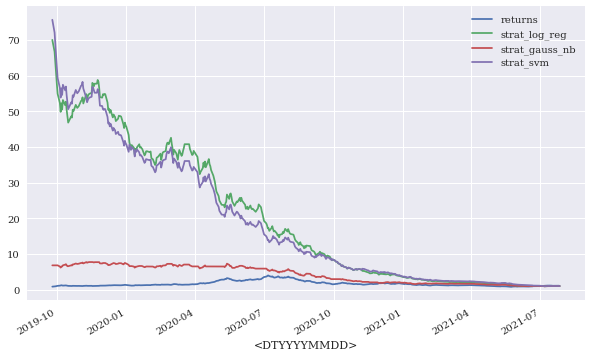

In [25]:
data = pd.DataFrame(raw[symbol])
data['returns'] = np.log(data / data.shift(1))
data['direction'] = np.sign(data['returns'])
lags = 5
create_lags(data)
data.dropna(inplace=True)
create_bins(data)
cols_bin
data.dropna(inplace=True)
fit_models(data)
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

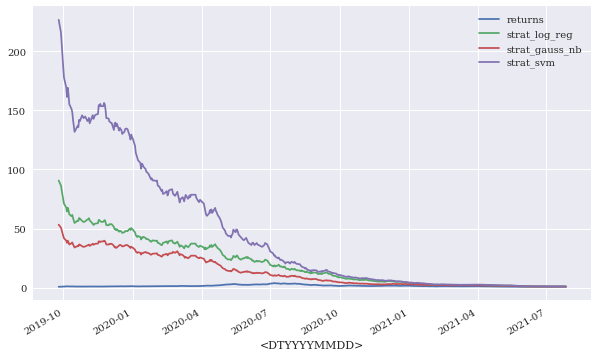

In [26]:
mu = data['returns'].mean()
v = data['returns'].std()
bins = [mu - v, mu, mu + v]
create_bins(data, bins)
data[cols_bin].head()
fit_models(data)
derive_positions(data)
evaluate_strats(data)
data[sel].sum().apply(np.exp)
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

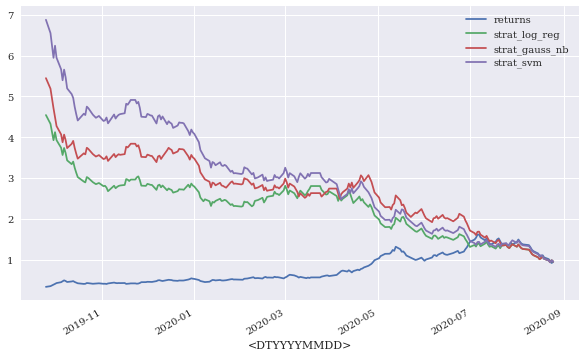

In [32]:
split = int(len(data) * 0.5)
train = data.iloc[:split].copy()
fit_models(train)
test = data.iloc[split:].copy()
derive_positions(test)
evaluate_strats(test)
test[sel].sum().apply(np.exp)
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

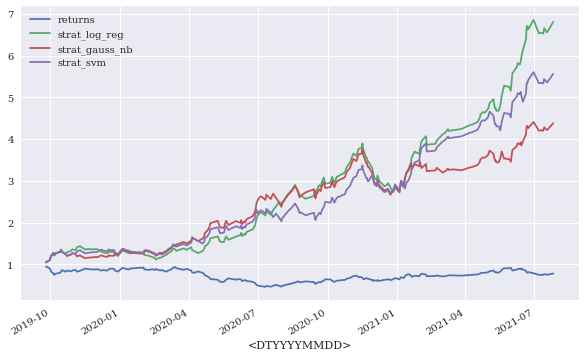

In [33]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.5,shuffle=True, random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()
fit_models(train)
derive_positions(test)
evaluate_strats(test)
test[sel].sum().apply(np.exp)
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [35]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=2 * [250],random_state=1)
%time model.fit(data[cols_bin], data['direction'])
data['pos_dnn_sk'] = model.predict(data[cols_bin])
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

Wall time: 11.3 s


C:\Users\BB\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


returns            0.819267
strat_dnn_sk    8670.297658
dtype: float64

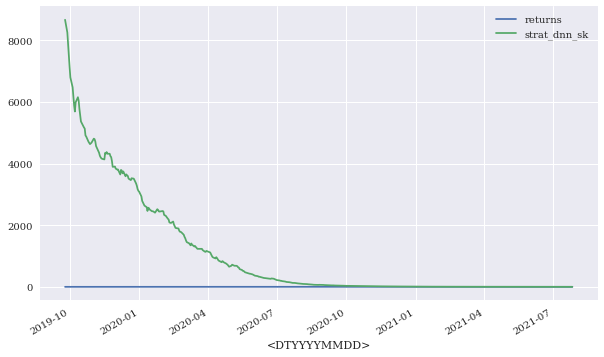

In [36]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [37]:
train, test = train_test_split(data, test_size=0.5,random_state=100)
train = train.copy().sort_index()
test = test.copy().sort_index()
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
hidden_layer_sizes=3 * [500], random_state=1)
%time model.fit(train[cols_bin], train['direction'])
test['pos_dnn_sk'] = model.predict(test[cols_bin])
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

Wall time: 2min 10s


C:\Users\BB\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

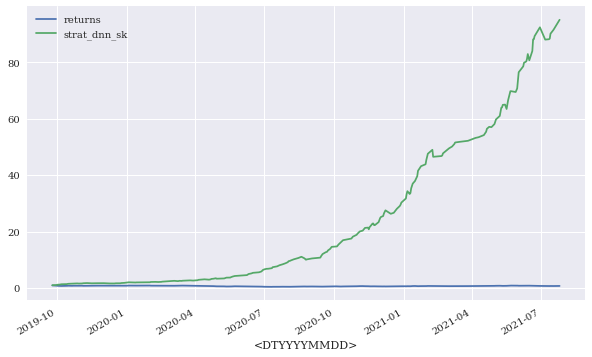

In [38]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
fc = [tf.contrib.layers.real_valued_column('lags', dimension=lags)]
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500],n_classes=len(bins) + 1,feature_columns=fc)
def input_fn():
    fc = {'lags': tf.constant(data[cols_bin].values)}
    la = tf.constant(data['direction'].apply(lambda x: 0 if x < 0 else 1).values,shape=[data['direction'].size, 1])
    return fc, la
%time model.fit(input_fn=input_fn, steps=250)
model.evaluate(input_fn=input_fn, steps=1)
pred = np.array(list(model.predict(input_fn=input_fn)))
data['pos_dnn_tf'] = np.where(pred > 0, 1, -1)
data['strat_dnn_tf'] = data['pos_dnn_tf'] * data['returns']
data[['returns', 'strat_dnn_tf']].sum().apply(np.exp)
data[['returns', 'strat_dnn_tf']].cumsum().apply(np.exp).plot(figsize=(10, 6));

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
pip install tensorflow==2.5

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.5 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.5


In [13]:
pip --version

pip 20.1.1 from C:\Users\BB\anaconda3\lib\site-packages\pip (python 3.8)Note: you may need to restart the kernel to use updated packages.


